In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
%matplotlib inline

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
metrics = context.catalog.load('train_metrics')

2020-12-04 13:14:12,875 - kedro.io.data_catalog - INFO - Loading data from `train_metrics` (PickleDataSet)...


DataSetError: Failed while loading data from data set PickleDataSet(backend=pickle, filepath=/home/boris/Documents/kaggle cassava/cassava/data/08_reporting/train_metrics.pkl, load_args={}, protocol=file, save_args={}).
[Errno 2] No such file or directory: '/home/boris/Documents/kaggle cassava/cassava/data/08_reporting/train_metrics.pkl'

In [ ]:
metrics['epochs']

In [ ]:
plt.figure()
sns.lineplot(data=metrics['train_losses'], label='train_loss')
plt.show()

plt.figure()
sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
plt.show()

In [6]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-04 13:14:39,212 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


{'accuracy': 0.46,
 'confusion_matrix': array([[ 2,  3,  0,  1,  6],
        [ 0,  2,  2, 13,  0],
        [ 0,  2,  4, 15,  1],
        [ 0,  0,  1, 33,  1],
        [ 0,  2,  3,  4,  5]]),
 'f1_score': 0.396004283578541}

In [15]:
!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4088  100  4088    0     0  12276      0 --:--:-- --:--:-- --:--:-- 12276
curl: (6) Could not resolve host: cf_matrix.py


In [19]:
from cf_matrix import make_confusion_matrix

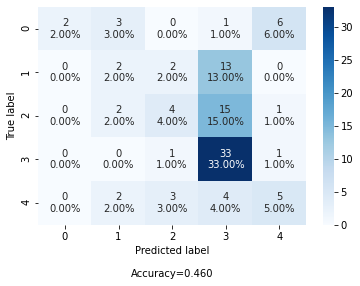

In [20]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [ ]:
model = context.catalog.load('model')

In [ ]:
model.eval()

In [ ]:
def plot_image(img, label=None, ax=None):
    if not ax:
        ax = plt.gca()
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    if label is not None:
        
        if isinstance(label, int):
            label = label_num_to_disease_map.get(label, 0)
        ax.set_title(f'L: {label}')

In [ ]:
train_images_torch = context.catalog.load('train_images_torch')

In [ ]:
from torchvision import transforms

In [ ]:
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_images_torch.transform = val_transform

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [ ]:
probabilities.detach().numpy()

In [ ]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = model.predict(image.unsqueeze(0))[0]
prediction = model.predict_label(image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()